### MCMC
- random-walk Metropolis algorithm
- <b>Def:</b>  MCMC generates samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. 

### Bayesian Formula:

$$ P(\theta | X ) = \frac{P(\theta) * P (X | \theta)}{P(X)}$$

We have $P(θ|x)$, the probability of our model parameters $\theta $ given the data x and thus our quantity of interest. To compute this we multiply the prior $P(θ)$ (what we think about θ before we have seen any data) and the likelihood $ P(x|θ) $, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x) $ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:

$$ P(X) = \int_\theta P(X,\theta) d\theta    $$


> Its hard to compute this bayes in closed form. So  Markov chain Monte Carlo (constructing a Markov chain to do Monte Carlo approximation

#### Conjugate
Conjugate means that our posterior will follow the same distribution as the prior


### Steps for MCMC:
-  At first, you find starting parameter position (can be randomly chosen)
-  you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. 
- The Metropolis sampler is very dumb and just takes a sample from a normal distribution centered around your current mu value (i.e. mu_current) with a certain standard deviation (proposal_width) that will determine how far you propose jumps 
- you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood

```python

likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal


```
p_accept = p_proposal / p_current

- we get an acceptance probability. You can already see that if p_proposal is larger, that probability will be > 1 and we'll definitely accept. However, if p_current is larger, say twice as large, there'll be a 50% chance of moving there:

- we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability relatively more often than those of low posterior probability.

In [21]:
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

W0602 13:21:39.596957 139950730774336 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
#tf.enable_eager_execution()

In [36]:
x_ = y_ = np.linspace(0.,5.,100.0,dtype = np.float32) 

X,Y  = evaluate(tf.meshgrid(x_,y_))

In [37]:
x_uni  = evaluate(tfpd.Uniform(low=0.0, high=5.0).prob(x_))
m = np.median(x_uni[x_uni>0])
x_uni[x_uni== 0] = m
y_uni  = evaluate(tfpd.Uniform(low=0.0, high=5.0).prob(y_))
m = np.median(y_uni[y_uni>0])
y_uni[y_uni== 0] = m

In [49]:
M_ = evaluate(tf.matmul(tf.expand_dims(x_uni,1),tf.expand_dims(y_uni,0)))
M_.shape

(100, 100)

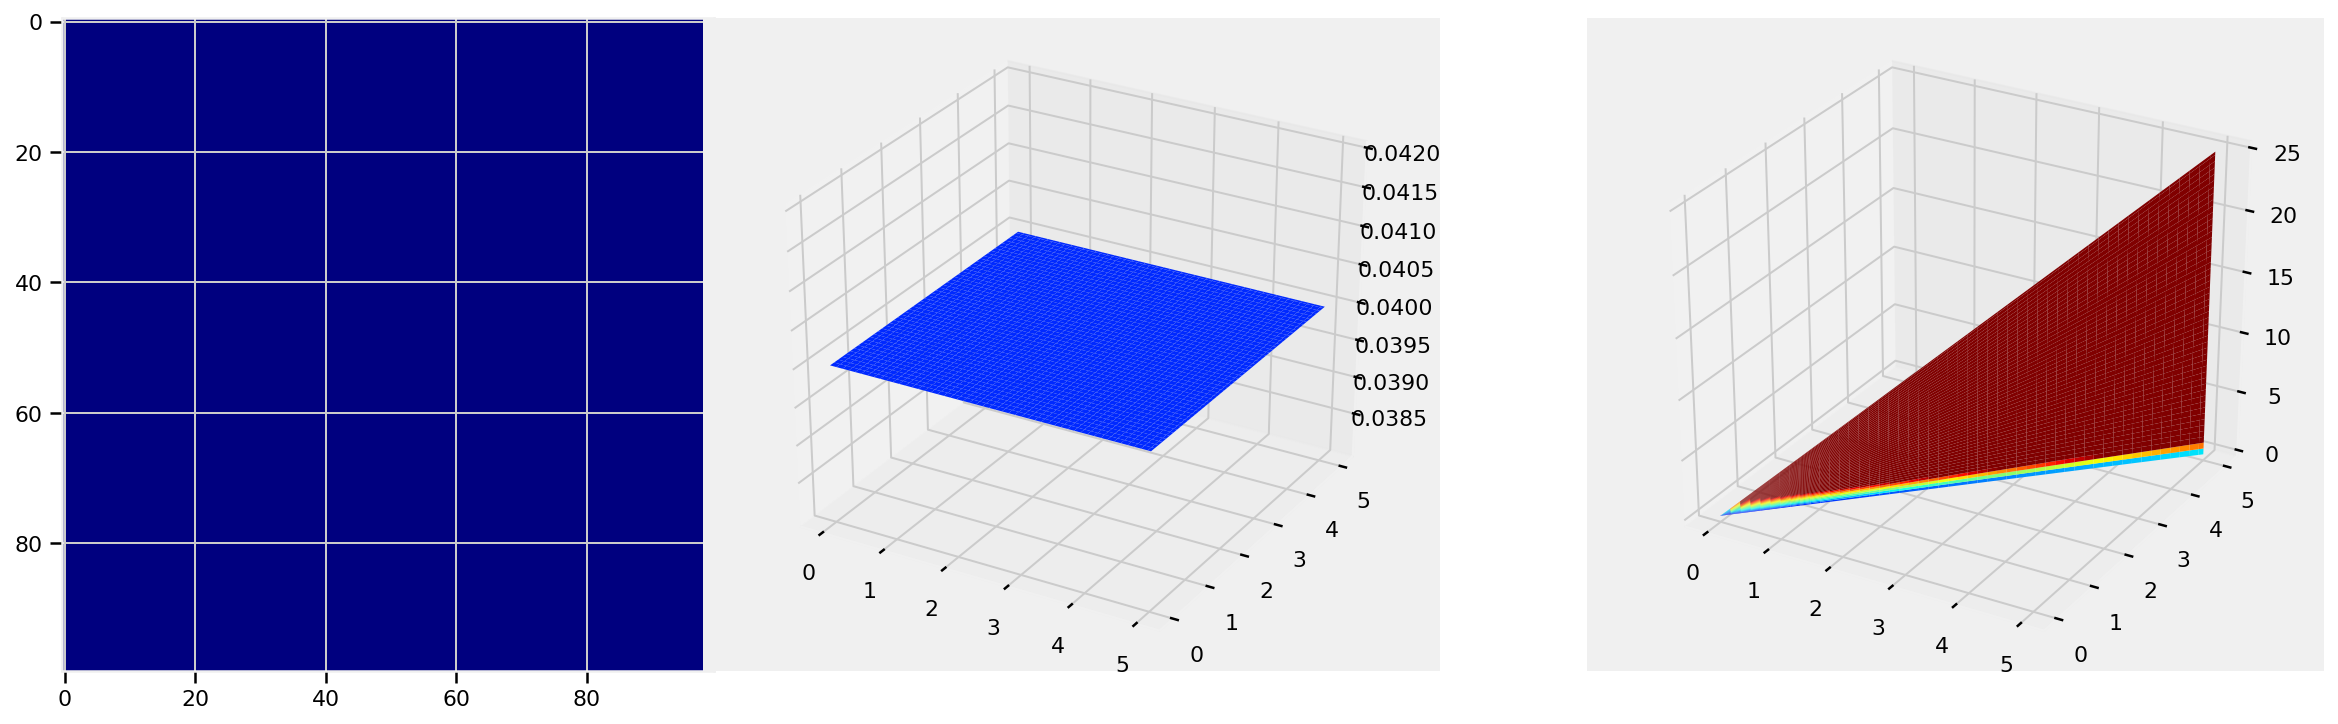

In [73]:
fig = plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(M_,cmap='jet')


# Mtemp_ = evaluate(tf.matmul(tf.expand_dims(x_,1),tf.expand_dims(y_,0)))
# Mtemp_.shape
# plt.imshow(Mtemp_)

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(Y_, Y_, Mtemp_, cmap=plt.cm.jet, vmax=1, vmin=-.15)

In [75]:
exp_x = evaluate(tfpd.Exponential(1/10).prob(x_))

exp_y = evaluate(tfpd.Exponential(1/3).prob(y_))

In [81]:
M_ = evaluate(tf.matmul(tf.expand_dims(exp_x,1),tf.expand_dims(exp_y,0)))

<Figure size 900x432 with 0 Axes>

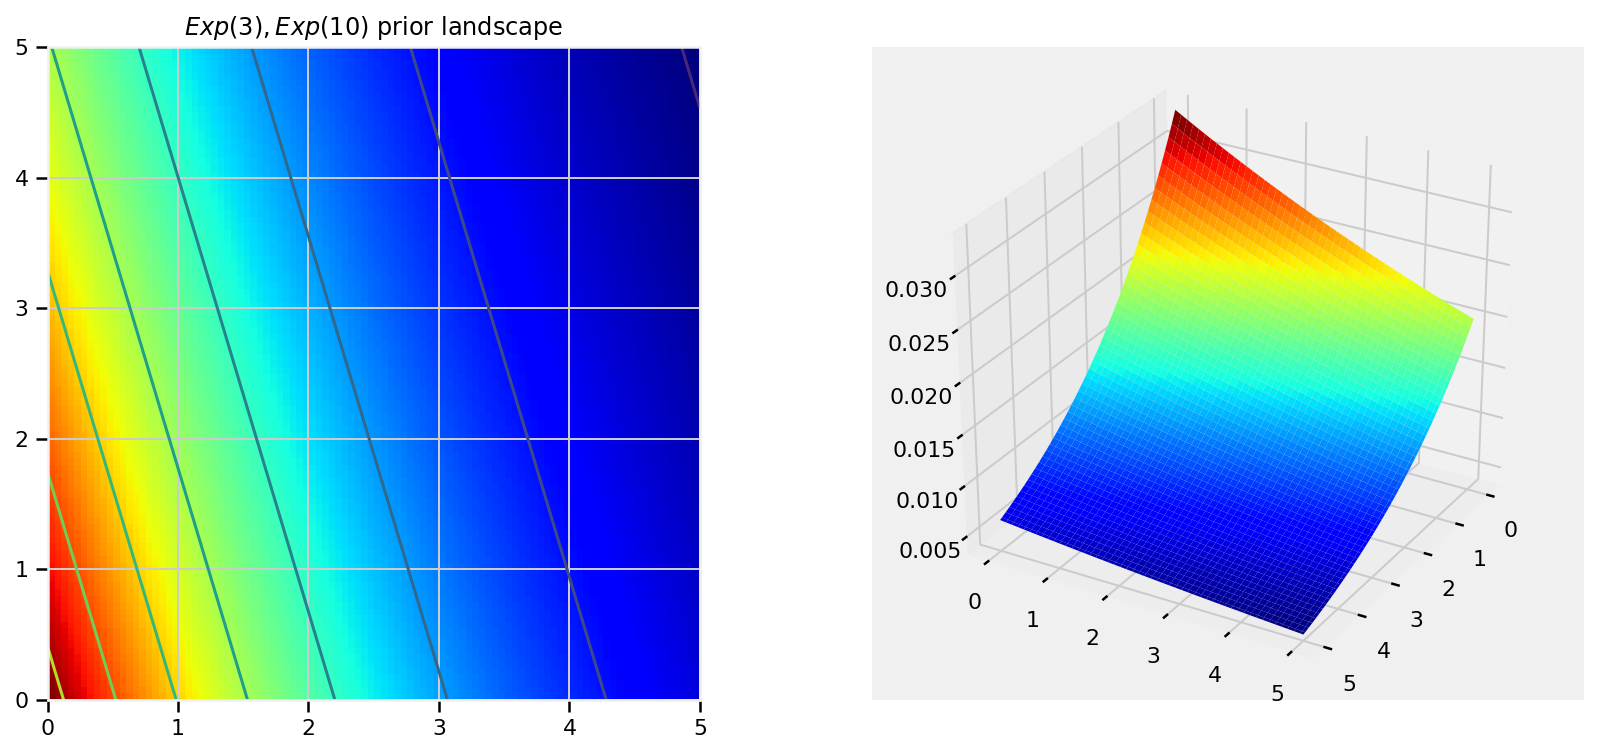

In [90]:
plt.figure(figsize(12.5, 6))
jet = plt.cm.jet
fig = plt.figure()
plt.subplot(121)
CS = plt.contour(X_, Y_, M_)
im = plt.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title(r"$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X_, Y_, M_, cmap=plt.cm.jet)
ax.view_init(azim=30)
#plt.title(r"$Exp(3), Exp(10)$ prior landscape; alternate view");

In [96]:
lambda_true1 = tf.constant(3.0)
lambda_true2 = tf.constant(8.0)
N = tf.constant(1)
data = evaluate(tf.concat([
    tfpd.Poisson(rate=lambda_true1).sample(sample_shape=(N,1)),
    tfpd.Poisson(rate=lambda_true2).sample(sample_shape=(N,1))
],axis=1))

In [102]:
print("observed: \n" % N, data)

observed: 
 [[1. 3.]]
